# Introduction and motivation

In [ ]:
## adding introduction

# statistical Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.data_loading import iter_reviews, load_beers_breweries_users
from src.data_processing import add_review_columns
from src.utils import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import re
from src.utils import tqdm
from src.plots import *
from src.data_loading import iter_reviews, load_beers_breweries_users, data_load, build_reviews_corpus
from src.data_processing import add_review_columns, review_counts_by, isEnglish
from src.plot_wordcloud import plot_wordcloud, tf_idf
from src.models import emotion_sentiment, polarity_sentiment
from src.text_processing import get_complaints_by_topic, get_complaints_by_beer_name, split_review, Lemmatizer, split_worst_and_best_reviews, get_top_attributes, get_tfidf_scores, get_word_counts, get_stop_words

In [3]:
rb_beers, rb_breweries, rb_users = load_beers_breweries_users("./data/RateBeer")
print(f'shape of beers dataset : {rb_beers.shape}\nshape of breweries dataset: {rb_breweries.shape}\nshape of users dataset: {rb_users.shape}')

rb_beers = add_review_columns("./data/RateBeer/reviews.txt", rb_beers, by="beer_id")
rb_users = add_review_columns("./data/RateBeer/reviews.txt", rb_users, by="user_id")
print(f'shape of beers dataset : {rb_beers.shape}\nshape of breweries dataset: {rb_breweries.shape}\nshape of users dataset: {rb_users.shape}')

shape of beers dataset : (442081, 17)
shape of breweries dataset: (24189, 4)
shape of users dataset: (70174, 5)


100%|██████████████████████████████████████████████████| 7122074/7122074 [01:33<00:00, 75874.15it/s]


shape of beers dataset : (396690, 19)
shape of breweries dataset: (24189, 4)
shape of users dataset: (70172, 7)


In [4]:
rb_users = rb_users[~rb_users.duplicated(subset='user_id', keep=False)]
print("Cheking number of missing values in each columns of rb_users:")
rb_users.isnull().sum()

Cheking number of missing values in each columns of rb_users:


nbr_ratings         0
user_id             0
user_name           0
joined             30
location        19575
review_count        0
avg_overall         0
dtype: int64

In [5]:
drop_columns = [
    "overall_score", "style_score", "zscore", "nbr_matched_valid_ratings", "avg_matched_valid_ratings"
]
rb_beers = rb_beers.drop(columns=drop_columns)

In [6]:
rb_beers.shape, rb_breweries.shape, rb_users.shape

((396690, 14), (24189, 4), (70112, 7))

In [7]:
import os

directory = "./data/RateBeer_processed"
if not os.path.exists(directory):
    os.makedirs(directory)

rb_beers.to_csv("./data/RateBeer_processed/beers.csv", index=False)
rb_breweries.to_csv("./data/RateBeer_processed/breweries.csv", index=False)
rb_users.to_csv("./data/RateBeer_processed/users.csv", index=False)

In [8]:
beers = pd.read_csv("./data/RateBeer_processed/beers.csv")
beers["beer_id"] = beers["beer_id"].astype("string")
beers.shape

(396690, 14)

In [9]:
popular_beers = beers[beers["review_count"] > 1000]
popular_beers.shape, popular_beers["review_count"].sum() # 566 beers, 1M reviews

((566, 14), 947257)

In [10]:
popular_beers_id = list(popular_beers["beer_id"])

In [11]:
popular_beers_reviews = [r for r in iter_reviews("./data/RateBeer/reviews.txt", do_cast=True)
                         if r["beer_id"] in popular_beers_id]

100%|██████████████████████████████████████████████████| 7122074/7122074 [02:23<00:00, 49708.18it/s]


In [ ]:
import langid


# non-english reviews have encoding issues and unique words that may bias our analysis (eg tf-idf), indicate that
non_english = 0
for review in tqdm(popular_beers_reviews):
    language, _ = langid.classify(review["text"])
    review["language"] = language
    if language != "en":
        non_english += 1

non_english / len(popular_beers_reviews) # ~5% non-english reviews

  0%|                                                                    | 0/947257 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████| 947257/947257 [59:57<00:00, 263.28it/s]


0.055327118194956594

In [25]:
pd.DataFrame(popular_beers_reviews).to_csv("./data/RateBeer_processed/popular_beers_reviews.csv", index=False)

In [ ]:
## plotting some statistaical information about the dataset 

# Loading data

In [2]:
# use this link to download all the needed dataframes: 
# https://drive.google.com/file/d/1GYsJh6MTX53RXv2qWh-G7FDmyi2JIZKz/view?usp=sharing

beers = pd.read_csv("./data/RateBeer_processed/beers.csv")
breweries = pd.read_csv("./data/RateBeer_processed/breweries.csv")
users = pd.read_csv("./data/RateBeer_processed/users.csv")
reviews = pd.read_csv("./data/RateBeer_processed/popular_beers_reviews.csv")
reviews = reviews[reviews["language"] == "en"]


beers.shape, breweries.shape, users.shape, reviews.shape

((396690, 14), (24189, 4), (70112, 7), (894848, 17))

In [3]:
# use this link to download graphs and all the needed dataframes and graphs: 
# https://drive.google.com/drive/folders/1wggLpvzeNB2IIY3vebOUGbSt7SwRFiQY?usp=drive_link

nb_reviews = 58824 # about 1M lines 
path_to_rating = "./data/RateBeer/reviews.txt"
# raw_data = data_load(path_to_rating, "all")
raw_data = data_load(path_to_rating, nb_reviews)

non_english_lines = [ind for ind, rev in enumerate(raw_data["review"]) if isEnglish(rev)]
enlgish_data = raw_data.loc[non_english_lines]

# Finding experts

In [4]:
expert_threshold = users["review_count"].quantile(0.9)
experts = users[users["review_count"] > expert_threshold]["user_id"].tolist()
expert_threshold

77.0

# Extracting features from beers

### using tf-idf

In [5]:
# NOTE some apostrophes have been replaced by â ? (eg canât, Iâm) this is probably an encoding issue
# (not on our end), but these get stripped by the TfidfVectorizer so we leave those as is
corpus, corpus_beers = build_reviews_corpus(reviews, sample_beers="all", expert_ids=experts)
print(corpus_beers[0])
print(corpus[0][:1000])

St Peters Cream Stout
Aroma: prunes and caramel.Taste: sweet molasses, subtle bitterness of dark chocolate and pine flavour. Not as creamy as expected, but a great beer! 
Pitch black with ruby reflections and small brown head. Sme?l is cocoa and roasted coffee. So is the taste plus smoked wood, by it feels like it lacks something in the mouth, which makes it a bit lightweight. 
Aroma of cocoa & milk chocolate. Black with brown long lasting head. Light sweet & medium dry. Medium body, creamy texture & average carbonation. 
Pours almost black with nice reddish hints. Low mocha head, decent retention and hints of lacing. Aroma is soft milk coffee and vanilla with the slightest dusty hint. It’s rather simple but clean and quite intense. Taste has a sweet foundation, milk coffee and the slightest hint of roasted malts, again vanilla and maybe a hint of berries. Overall medium sweet and light to medium bitter, with a touch of burnt caramel in the finish. Medium bodied with very low carbonati

In [6]:
tokenizer = Lemmatizer
stop_words = get_stop_words(corpus, tokenizer=tokenizer)
word_counts = get_word_counts(corpus, corpus_beers, tokenizer=tokenizer, stop_words=stop_words, min_df=0.02)

c:\Users\ssaba\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['pa'] not in stop_words.
  warnings.warn(


In [48]:
tfidf_scores = get_tfidf_scores(word_counts)
top_attributes = get_top_attributes(tfidf_scores, top_attributes=80)

In [49]:
top_attributes.to_csv("./data/RateBeer_processed/top_attributes.csv")


In [50]:
top_attributes.head()

,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_10,...,attr_71,attr_72,attr_73,attr_74,attr_75,attr_76,attr_77,attr_78,attr_79,attr_80
beer_name,,,,,,,,,,,,,,,,,,,,,
St Peters Cream Stout,chocolate,coffee,stout,chocolate coffee,coffee chocolate,roasty,chocolate chocolate,chocolate stout,coffee stout,licorice,...,chocolate raisin,chocolate molasses,coffee opaque,tar,plum,molasses chocolate,liquorice chocolate,coffee liquorice,coffee bean,chocolate espresso
Evil Twin Imperial Biscotti Break,chocolate,coffee,chocolate coffee,coffee chocolate,biscotti,pitch,cocoa,almond,espresso,mocha,...,bourbon,coffee imperial,raisin,chocolate molasses,cocoa chocolate,coffee liqueur,lacing,chocolate cookie,stout coffee,chocolate roasty
Schneider Weisse Original,clove,hefe,hefeweizen,weizen,weisse,cleave,schneider,hefes,german,weissbier,...,weissen,schneiders,opaque,clove hefes,hefeweizen cleave,hefeweizen hefe,hefes clove,weizenbier,nutmeg clove,clovey
Port Brewing Older Viscosity,bourbon,chocolate,oak,bourbon chocolate,chocolate bourbon,bourbon oak,oak bourbon,coffee,bourbon bourbon,barrel,...,burnt,beige,sauce,fudge,booze chocolate,chocolate molasses,bourbon whiskey,whisky,tobacco,leather
Speakeasy Big Daddy IPA,grapefruit,piney,speakeasy,west coast,resin,daddy,coast,west,ipas,francisco,...,cascade grapefruit,blond,bland,grapefruit bomber,assault,piney decently,radekfest,hum,grapefruit lemongrass,rattle hum


In [56]:
from transformers import pipeline
classified_features = pd.DataFrame(columns=["appearance", "aroma", "palate", "taste"], index=top_attributes.index)
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device = 'cuda')
categories = ["appearance", "aroma", "palate", "taste"]

for i in np.arange(top_attributes.shape[0]):
    features = top_attributes.iloc[i].values
    appearance = []
    aroma = []
    palate = []
    taste = []
    for feature in features:
        result = classifier(feature, candidate_labels=categories)
        if result['labels'][0] == "appearance" and result['scores'][0]>0.5:
            appearance.append(feature)
        elif result['labels'][0] == "aroma" and result['scores'][0]>0.5:
            aroma.append(feature)
        elif result['labels'][0] == "palate" and result['scores'][0]>0.5:
            palate.append(feature)
        elif result['labels'][0] == "taste" and result['scores'][0]>0.5:
            taste.append(feature)
        #print(f"Feature: {feature}")
        #print(f"Predicted Category: {result['labels'][0]} (Score: {result['scores'][0]:.4f})\n")
    classified_features.loc[top_attributes.index[i], 'appearance'] = appearance
    classified_features.loc[top_attributes.index[i], 'aroma'] = aroma
    classified_features.loc[top_attributes.index[i], 'palate'] = palate
    classified_features.loc[top_attributes.index[i], 'taste'] = taste


In [57]:
classified_features

,appearance,aroma,palate,taste
beer_name,,,,
St Peters Cream Stout,"[opaque, jerusalem, prune]","[roasted, raisin, roastiness]","[peter, plum]","[chocolate, coffee, coffee chocolate, chocolat..."
Evil Twin Imperial Biscotti Break,"[imperial, twin, opaque]","[roasted, raisin]","[chocolate booze, coffee booze]","[chocolate, coffee, coffee chocolate, biscotti..."
Schneider Weisse Original,"[muddy, brownish, phenolic, opaque]","[clove, hefe, hefes, bubblegum, cloves, clove ...","[cleave, bavarian]","[weizen, weisse, wheaty, dunkelweizen, weisses..."
Port Brewing Older Viscosity,"[port, abbey, prune, opaque, leather]","[oak, raisin, oil]","[bourbony, bourbon booze, sipper]","[chocolate, coffee, molasses, boozy, coffee bo..."
Speakeasy Big Daddy IPA,"[daddy, toronado, needle, haze, hopheads, spru...","[apa, resinous piney, grapefruit lemongrass]","[piney, coast, untouchable, stone, piny, coast...","[resiny, grapefruity, mango, juicy, zest, grap..."
...,...,...,...,...
Shock Top Belgian White,"[blue moon, moon, macro, artificial, fake, air...","[anheuser, clove, hefe, coriander clove]","[bland, cleave, lcbo]","[witbiers, wheaty, zest, coriander wit, budwei..."
Het Anker Gouden Carolus Classic,"[prune, reddish, port, figs, brownish, reddish...","[raisin, raisins, vinous, clove, keizer, anise...","[plum, bsa, blauw]","[chocolate, coffee, molasses, coffee chocolate..."
Allagash Dubbel Reserve,"[reddish, abbey, prune, port, figs, brownish, ...","[allagash, raisin, clove, raisins, raisons]","[plum, cleave]","[dubbel, chocolate, chocolate dubbel, coffee, ..."


In [60]:
classified_features.to_csv("./data/RateBeer_processed/classified_features.csv")

### using LDA

In [ ]:
#data = pd.read_pickle("./data/review_with_emotions.pkl")
# lda_by_beers(data, 7)
data = pd.read_pickle("./data/results_lda.pkl")

In [85]:
from gensim import models
model_lda = models.LdaModel.load("./data/LDA_model.pkl")
for x in model_lda.print_topics(num_topics=7, num_words=5):
    print("Topic", x[0], ":", x[1])

Topic 0 : 0.036*"hazy" + 0.022*"orange" + 0.021*"golden" + 0.019*"yellow" + 0.019*"yeast"
Topic 1 : 0.048*"sour" + 0.032*"tart" + 0.020*"bottle" + 0.018*"red" + 0.015*"fruit"
Topic 2 : 0.026*"citrus" + 0.025*"hop" + 0.024*"orange" + 0.022*"hops" + 0.021*"hoppy"
Topic 3 : 0.047*"roasted" + 0.043*"black" + 0.042*"chocolate" + 0.039*"brown" + 0.029*"coffee"
Topic 4 : 0.032*"golden" + 0.022*"bottle" + 0.021*"pale" + 0.020*"malty" + 0.016*"yellow"
Topic 5 : 0.043*"brown" + 0.033*"caramel" + 0.028*"amber" + 0.023*"malty" + 0.022*"bottle"
Topic 6 : 0.019*"like" + 0.013*"one" + 0.012*"little" + 0.010*"much" + 0.009*"color"


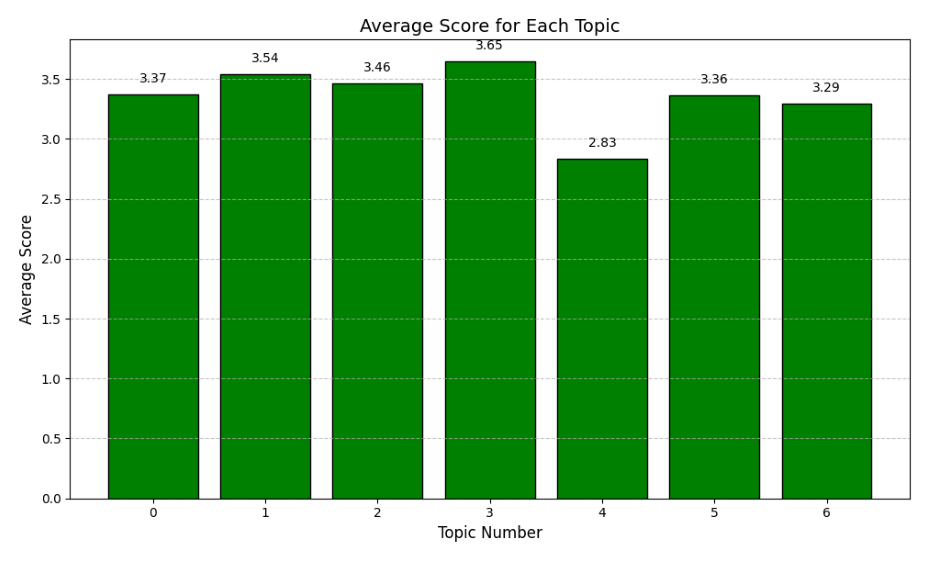

In [87]:
# data = pd.read_pickle("lda_by_beer/results_lda.pkl")
# plot_avg_score_by_topic(data)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig, ax = plt.subplots(figsize=(10, 6))
img = mpimg.imread('graphs/average_score_by_topic.png')
ax.imshow(img)
plt.tight_layout()
plt.axis('off')
plt.show()

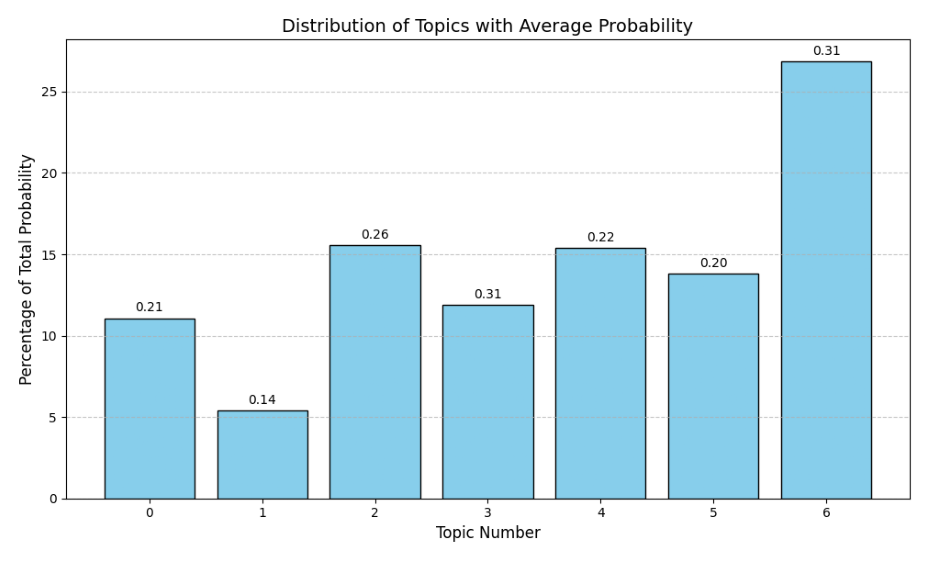

In [88]:
# data = pd.read_pickle("lda_by_beer/results_lda.pkl")
# plot_topic_distrib(data)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig, ax = plt.subplots(figsize=(10, 6))
img = mpimg.imread('graphs/distribution_topics.png')
ax.imshow(img)
plt.tight_layout()
plt.axis('off')
plt.show()

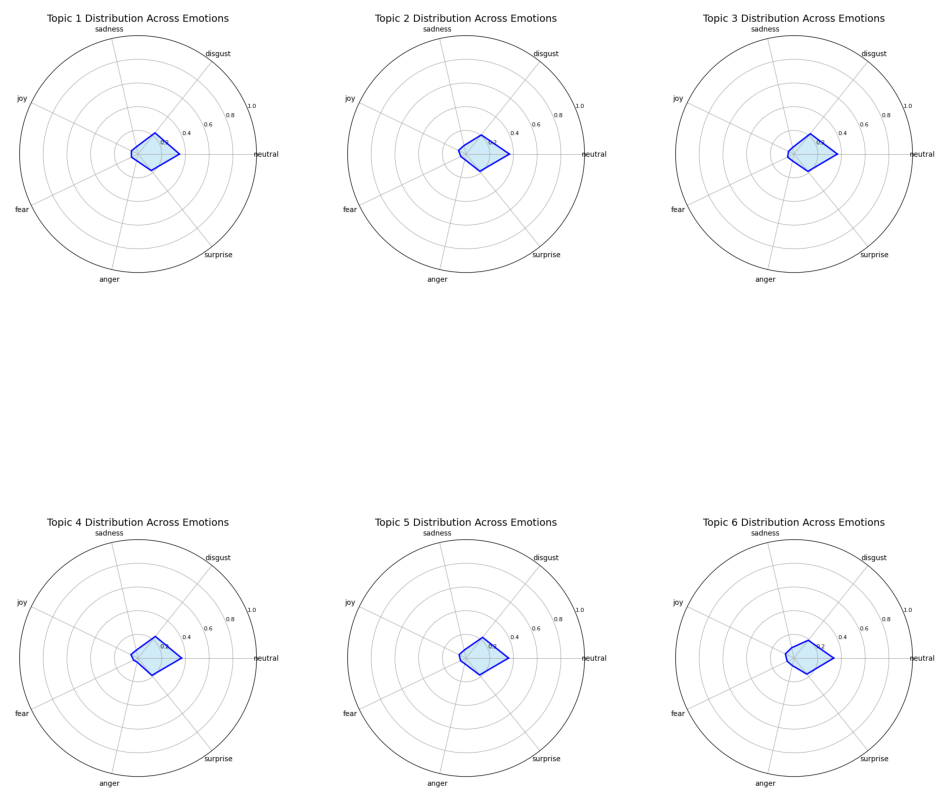

In [89]:
# data = pd.read_pickle("lda_by_beer/results_lda.pkl")
# plot_topic_emotions_distrib(data)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgs = [mpimg.imread('graphs/radar_graph_emotions_by_topic_1.png'), mpimg.imread('graphs/radar_graph_emotions_by_topic_2.png'), mpimg.imread('graphs/radar_graph_emotions_by_topic_3.png'), mpimg.imread('graphs/radar_graph_emotions_by_topic_4.png'), mpimg.imread('graphs/radar_graph_emotions_by_topic_5.png'), mpimg.imread('graphs/radar_graph_emotions_by_topic_6.png')]
_, axs = plt.subplots(2, 3, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.axis('off') 
    ax.imshow(img)
plt.show()

# Extracting negative features

### Using tf-idf

In [58]:
neg_reviews, pos_reviews = split_worst_and_best_reviews(reviews, 10)

neg_corpus, beer_names = build_reviews_corpus(neg_reviews, sample_beers="all")
pos_corpus, _ = build_reviews_corpus(pos_reviews, sample_beers="all")

neg_counts = get_word_counts(neg_corpus, beer_names, tokenizer=tokenizer, stop_words=stop_words, min_df=0.02)
pos_counts = get_word_counts(pos_corpus, beer_names, tokenizer=tokenizer, stop_words=stop_words, vocabulary=neg_counts.columns)

c:\Users\ssaba\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['pa'] not in stop_words.
  warnings.warn(
c:\Users\ssaba\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['pa'] not in stop_words.
  warnings.warn(


In [63]:
scores = get_tfidf_scores(neg_counts) - get_tfidf_scores(pos_counts)
top_criticisms = get_top_attributes(scores, column_prefix="crit_", top_attributes=80)

In [64]:
top_criticisms

,crit_1,crit_2,crit_3,crit_4,crit_5,crit_6,crit_7,crit_8,crit_9,crit_10,...,crit_71,crit_72,crit_73,crit_74,crit_75,crit_76,crit_77,crit_78,crit_79,crit_80
beer_name,,,,,,,,,,,,,,,,,,,,,
St Peters Cream Stout,stout,coffe,motor oil,coffee,motor,english,mocca,oil,imperial stout,treacle,...,melange,milk shake,chocolate thinner,oxidised,conservative,counteract,environment,phone,lke,remembered
Evil Twin Imperial Biscotti Break,almond,stout,boozy,york,extract,ash,impy,liqueur,bomber,sweeten,...,bottlesource atlantaappearance,richness,noted,unsophisticated,salvage,centric,hater,coffee liquorice,intensifies,stout impy
Schneider Weisse Original,minerality,wheatiness,weisse,muddy,footed,disappointing,cloudiness,thins,complimentary,disappointment,...,photo,flare,bannana,future,judgement,sence,dislike,cilantro,drab,solidly
Port Brewing Older Viscosity,barrel,viscosity,bottlesource,boozy,whiskey,tannin,cage,bourbon barrel,december,booziness,...,occasional,oak oak,whoa,pancake,tar,mike,plum raisins,marshmallow,perception,splash
Speakeasy Big Daddy IPA,fold,anemic,box,synthetic,soggy,shallow,bay,brewpub,clingy,goblet,...,martint,dig,unattractive,harmony,whew,county,club soda,yawn,western,overpoweringly
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Shock Top Belgian White,anheuser,anheuser busch,garbage,busch,budweiser,sink,waste,money,free,piss,...,brewmaster,graphic,skanky,pee pee,wit,kilter,swap,soda soda,preferable,mishandle
Het Anker Gouden Carolus Classic,emperor,coffee,prune chocolate,beutiful,coffee ruby,allright,bro,alco,beige burnt,brownish beige,...,thinly,numerical longer,plummy,contains,inconsistent,voluminous,hello,raisen,stuffy,application
Allagash Dubbel Reserve,dubbels,double,abbey,tripel,blind,blind abbey,beige dried,crab,steam,hazelnut,...,rapidly,yespr,disappointing,chocolaty,slighlty,unimpressive,poured reddish,anniversary,nasty nasty,cassis


In [65]:
top_criticisms.to_csv("./data/RateBeer_processed/top_criticisms.csv")

In [163]:
from transformers import pipeline
neg_classified_features = pd.DataFrame(columns=["appearance", "aroma", "palate", "taste"], index=top_criticisms.index)
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device = 'cuda')
categories = ["appearance", "aroma", "palate", "taste"]

for i in np.arange(top_criticisms.shape[0]):
    features = top_criticisms.iloc[i].values
    appearance = []
    aroma = []
    palate = []
    taste = []
    for feature in features:
        result = classifier(feature, candidate_labels=categories)
        if result['labels'][0] == "appearance" and result['scores'][0]>0.5:
            appearance.append(feature)
        elif result['labels'][0] == "aroma" and result['scores'][0]>0.5:
            aroma.append(feature)
        elif result['labels'][0] == "palate" and result['scores'][0]>0.5:
            palate.append(feature)
        elif result['labels'][0] == "taste" and result['scores'][0]>0.5:
            taste.append(feature)
        #print(f"Feature: {feature}")
        #print(f"Predicted Category: {result['labels'][0]} (Score: {result['scores'][0]:.4f})\n")
    neg_classified_features.loc[top_criticisms.index[i], 'appearance'] = appearance
    neg_classified_features.loc[top_criticisms.index[i], 'aroma'] = aroma
    neg_classified_features.loc[top_criticisms.index[i], 'palate'] = palate
    neg_classified_features.loc[top_criticisms.index[i], 'taste'] = taste



In [164]:
neg_classified_features

,appearance,aroma,palate,taste
beer_name,,,,
St Peters Cream Stout,"[thinner, image, carpet, imperial, emerge, gui...","[oil, ache, fratto, toffe, mint, skunk, olive]","[foul, letdown, cough, honest]","[coffee, imperial stout, stout coffee, fig cho..."
Evil Twin Imperial Biscotti Break,"[ash, impy, premier, snow, hype, bottlesource ...",[stout impy],"[york, chocolate booze]","[boozy, sweeten, chocolate raspberry, cookie, ..."
Schneider Weisse Original,"[muddy, cloudiness, monkey, standout, reddish,...","[clove gum, bannana]","[disappointment, bland, sewage, consistency, t...","[weisse, complimentary, undertones, tickle, ac..."
Port Brewing Older Viscosity,"[cage, cork cage, hogtownharry, wispy, opaque]","[april, april bottlesource, oak barrel, anise,...","[capone, tough, blankboy, spite]","[boozy, whiskey, chocolate sauce, bodyflavor, ..."
Speakeasy Big Daddy IPA,"[anemic, synthetic, clingy, nominal, largish, ...","[parfume, mint, rastacouere]","[bay, confuse, bland tasteless, piny, lable, a...","[breadiness, chocolate cacao, perrier, cassis,..."
...,...,...,...,...
Shock Top Belgian White,"[indicative, fake, design, town, twin, sweat s...","[anheuser, lather, ave]","[crap, waste money, vomit, pathetic, bother, s...","[budweiser, lager, flavoured, bartender, suck,..."
Het Anker Gouden Carolus Classic,"[emperor, glow, wall adhesive, adhesive collar...","[chamomile, raisen]","[condense, plum burnt, difficulty]","[coffee, prune chocolate, coffee ruby, acid ta..."
Allagash Dubbel Reserve,"[abbey, blind abbey, mahogony, lackluster, hot...","[alc, beige clove, clove cleave, vinous raisin]","[pater, matly]","[port chocolate, worthwhile, chocolaty, nasty ..."


In [165]:
neg_classified_features.to_csv("./data/RateBeer_processed/neg_classified_features.csv")

In [67]:
beers_with_attributes = beers.merge(top_attributes.reset_index(), on="beer_name")
beers_with_attributes = beers_with_attributes.merge(top_criticisms.reset_index(), on="beer_name")
beers_with_attributes.to_csv("./data/RateBeer_processed/popular_beers_with_attributes.csv", index=False)

In [ ]:
def top_attributes(beers, top_count=5, column_count=10, column_prefix="attr_"):
    attributes = beers.melt(
        id_vars='location', 
        value_vars=[f'{column_prefix}{i+1}' for i in range(column_count)],
        var_name='attribute_type', 
        value_name='attribute'
    )
    
    attribute_counts = attributes.groupby(['location', 'attribute']).size().reset_index(name='count')
    
    top_attributes = (
        attribute_counts.sort_values(by=['location', 'count'], ascending=[True, False])
        .groupby('location')
        .head(top_count)
    )
    
    top_attributes_pivoted = (
        top_attributes.assign(rank=top_attributes.groupby('location').cumcount() + 1)
        .pivot(index='location', columns='rank', values='attribute')
        .reset_index()
    )
    
    top_attributes_pivoted.columns = ['location'] + [f"top_{column_prefix}{i+1}" for i in range(top_count)]

    return top_attributes_pivoted

In [108]:
beers = pd.read_csv("./data/RateBeer_processed/popular_beers_with_attributes.csv")


In [120]:
# among general attributes
top_attributes(beers, top_count=10, column_count=10).head(5)

,location,top_attr_1,top_attr_2,top_attr_3,top_attr_4,top_attr_5,top_attr_6,top_attr_7,top_attr_8,top_attr_9,top_attr_10
0,Argentina,bland,cerveza,corn,corn corn,corny,lager,lager lager,macro,macro lager,straw
1,Australia,cooper,lager,bland,condition,floaties,go,outback,particle,sediment,straw
2,Austria,brandy,chocolate,cognac,doppelbock,molasses,plum,port,raisin,samichlaus,vintage
3,Belgium,raisin,beige,chocolate,plum,reddish,coriander,ruby,clove,lambic,funk
4,Brazil,chocolate,coffee,cola,lager,licorice,molasses,opaque,roasted,roasty,schwarzbier


In [128]:
# among negative attributes
top_attributes(beers, top_count=15, column_count=70, column_prefix="crit_").head(5)

,location,top_crit_1,top_crit_2,top_crit_3,top_crit_4,top_crit_5,top_crit_6,top_crit_7,top_crit_8,top_crit_9,top_crit_10,top_crit_11,top_crit_12,top_crit_13,top_crit_14,top_crit_15
0,Argentina,adjunct corn,adjuncty,aluminium,avoid,ball,bile,bleach,boil,budweiser,burntness,cabbage,contender,corn awful,corn bore,crap
1,Australia,awful,claim,cub,homebrew,mesa,perrier,shit,skunk,thrown measure,vomit,ack,alchoholic,alkohol,alongside,america
2,Austria,adam,apples,bag,barleywines,beige raisin,bla,brewed,brownish,cherries,chicken,christmas,cloyingly,coke,complete,cook
3,Belgium,vinegar,cider,acid,disappointing,artificial,bland,boozy,champagne,lambic,cola,lambics,abbey,chemical,overrate,skunk
4,Brazil,adjunct,adjunct corn,artificial,artificial sweetener,beige,bland,bland flavorless,branch,burnt,burnt burnt,chap,chime,coca,coca cola,cola


### Using emotion analysis

In [129]:
# data = emotion_sentiment(enlgish_data, cuda=True)
# user = pd.read_csv("data/RateBeer/users.csv") # We merge on users.csv to get the location of the users
# data = data.merge(user, on="user_id") 
data = pd.read_pickle("./data/review_with_emotions.pkl")

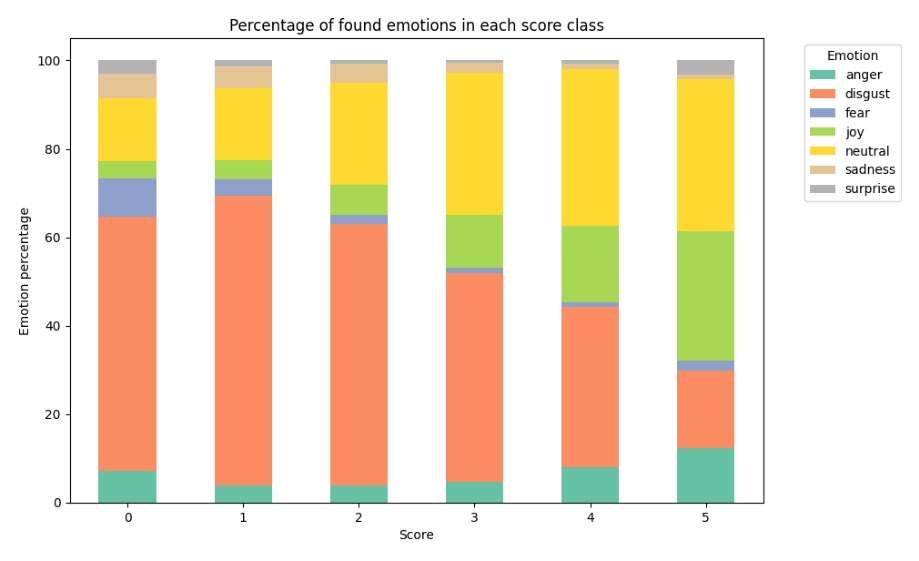

Spearman correlation for emotions by score: 
(if p value < 0.05 we can say that a change in score, introducted a predictable increase or decrease in the percentage for that emotion) 
          Spearman correlation   
anger                 0.600000  
disgust              -0.828571  
fear                 -0.657143  
joy                   1.000000  
neutral               0.942857  
sadness              -1.000000  
surprise              0.028571  



In [131]:
# plot_emotion_by_score_spearman(data)

fig, ax = plt.subplots(figsize=(10, 6))
img = mpimg.imread('graphs/emotions_by_class.png')
ax.imshow(img)
plt.tight_layout()
plt.axis('off')
plt.show()

with open("graphs/spearman_output.out", "r") as f:
    print(f.read())

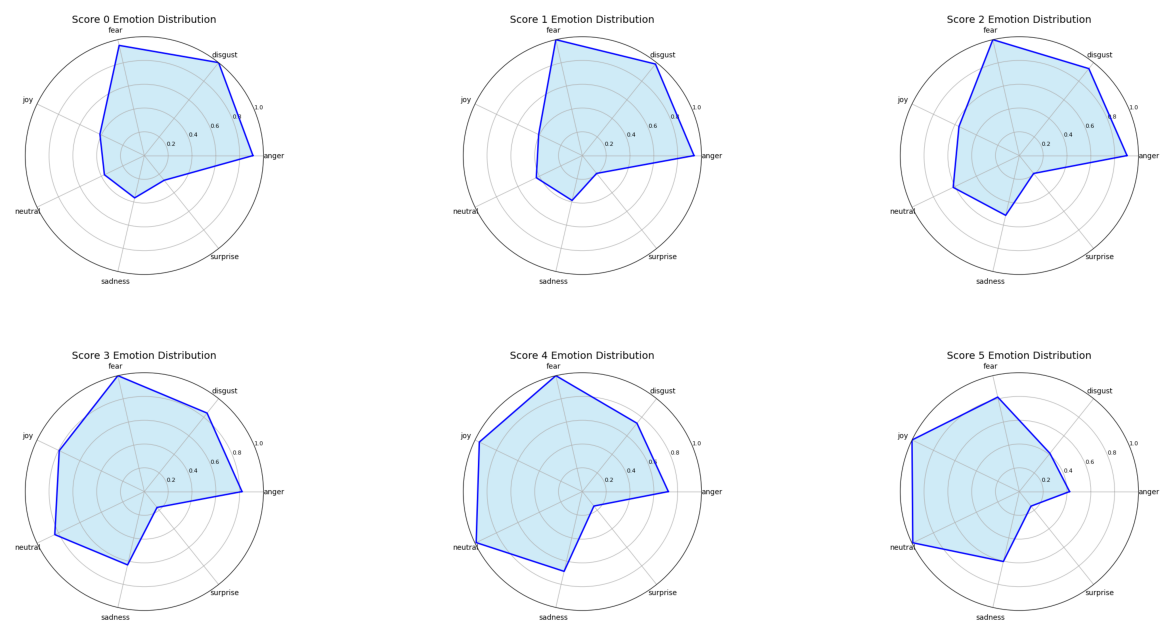

In [132]:
# data = pd.read_pickle("lda_by_beer/results_lda.pkl")
# plot_score_emotions_distrib(data)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgs = [mpimg.imread('graphs/radar_graph_emotions_by_score_0.png'),
        mpimg.imread('graphs/radar_graph_emotions_by_score_1.png'), 
        mpimg.imread('graphs/radar_graph_emotions_by_score_2.png'),
        mpimg.imread('graphs/radar_graph_emotions_by_score_3.png'),
        mpimg.imread('graphs/radar_graph_emotions_by_score_4.png'),
        mpimg.imread('graphs/radar_graph_emotions_by_score_5.png'),]
_, axs = plt.subplots(2, 3, figsize=(16, 8))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.axis('off') 
    ax.imshow(img)
plt.show()

In [134]:
def split_review(review):
    return re.split('\\;|\\.|\\?|\\!', review) # tokenize on sentences (by . ; ? !)

In [141]:
split_data = []
for idx, row in data[((data["score"] == 5) | (data["score"] == 4))].iterrows():
    review_chunks = split_review(row['review']) 
    for chunk in review_chunks:
        split_data.append({'beer_name': row['beer_name'], 'review': chunk})

split_df = pd.DataFrame(split_data)

In [152]:
split_df

,beer_name,review
0,Régab,I nreally think that people that put comments ...
1,Régab,This is just one of the finest brew in the af...
2,Régab,So please stop misleading people
3,Régab,So Vive la regab
4,Régab,
...,...,...
21194078,Brauhaus Rose,"Clear bright deep amber color, solid white he..."
21194079,Brauhaus Rose,Aroma of toasted biscuit
21194080,Brauhaus Rose,"Taste is sweet burnt toast, light smoke"
21194081,Brauhaus Rose,My favorite of the bunch


In [ ]:
# tokens_feeling = emotion_sentiment(split_df, cuda=True)
#tokens_feeling = pd.read_pickle("./data/review_with_tokens_emotions.pkl")


In [151]:
# tokens_feeling = pd.read_pickle("review_with_tokens_emotions.pkl")
# topic_by_beer = pd.read_pickle("lda_by_beer/results_lda.pkl")
# topic_index = 2
# get_complaints_by_topic(topic_by_beer, tokens_feeling, topic_index)
with open("graphs/complaints_topic2.out", "r") as f:
    print(f.read())

Final Summary of All Complaints:
The Only Peachy color and half cloudy look lingering and piney quite a hoppy nose . Pours a hazy amber color with a dense off white head but not great stuff! The cask version is more dry hopped and the mouthfeel is much more oily . The taste is very pungently bitter but this was hugely unbalanced Amber beer .




In [155]:
# df = pd.read_pickle("review_with_tokens_emotions.pkl")
# beer_name = "Rochefort Trappistes 10"
# get_complaints_by_beer_name(df, beer_name)
with open("graphs/complaints_beer.out", "r") as f:
    print(f.read())

Final Summary of All Complaints:
The Rochefort Trappistes 10 pours a very dark brown to nearly black with a bubbly light tan head that lasts forever and leaves thick lacing full of dark fruits . Pours a dark prune colour with an endless beige head of champagne like bubbles . Tastes quite Christmassy with a thick treacle like taste .


In [156]:
### Adding extracting features from complaints
### add classification

# Following the clues : what drives negativity

### Emotion and negativity with location

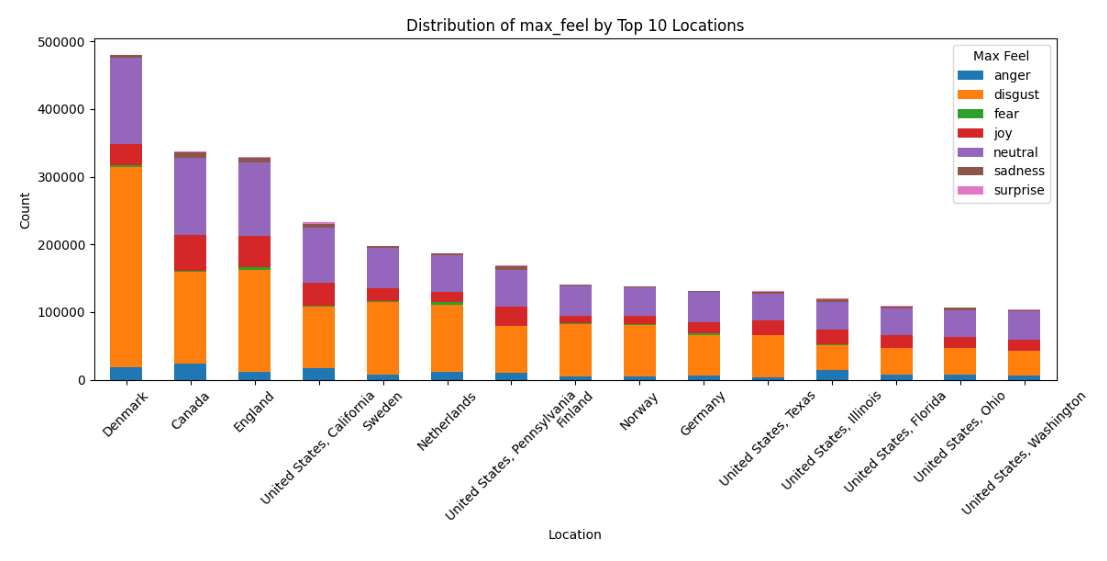

In [157]:
# data = pd.read_pickle("review_with_emotions.pkl")
# plot_emotion_loc_distrib(data)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig, ax = plt.subplots(figsize=(12, 6))
img = mpimg.imread('graphs/max_feel_by_loc.png')
ax.imshow(img)
plt.tight_layout()
plt.axis('off')
plt.show()

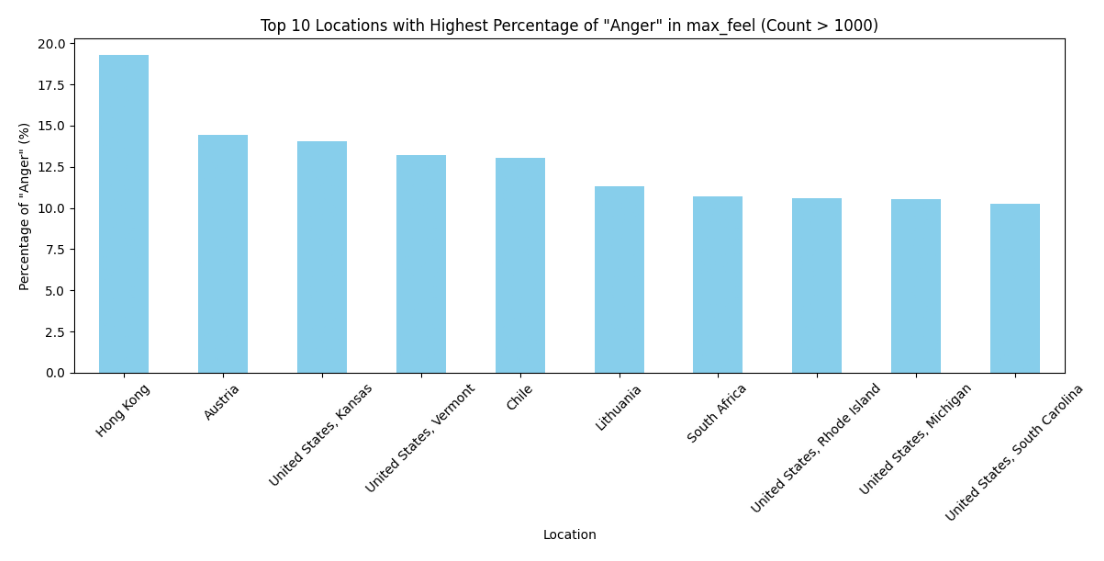

In [159]:
# data = pd.read_pickle("review_with_emotions.pkl")
# threshold = 1000
# emotion_name = "anger"
# top_n = 10
# plot_top_loc_emotion(data, threshold, emotion_name, top_n)


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig, ax = plt.subplots(figsize=(12, 6))
img = mpimg.imread('graphs/max_anger_by_loc.png')
ax.imshow(img)
plt.tight_layout()
plt.axis('off')
plt.show()

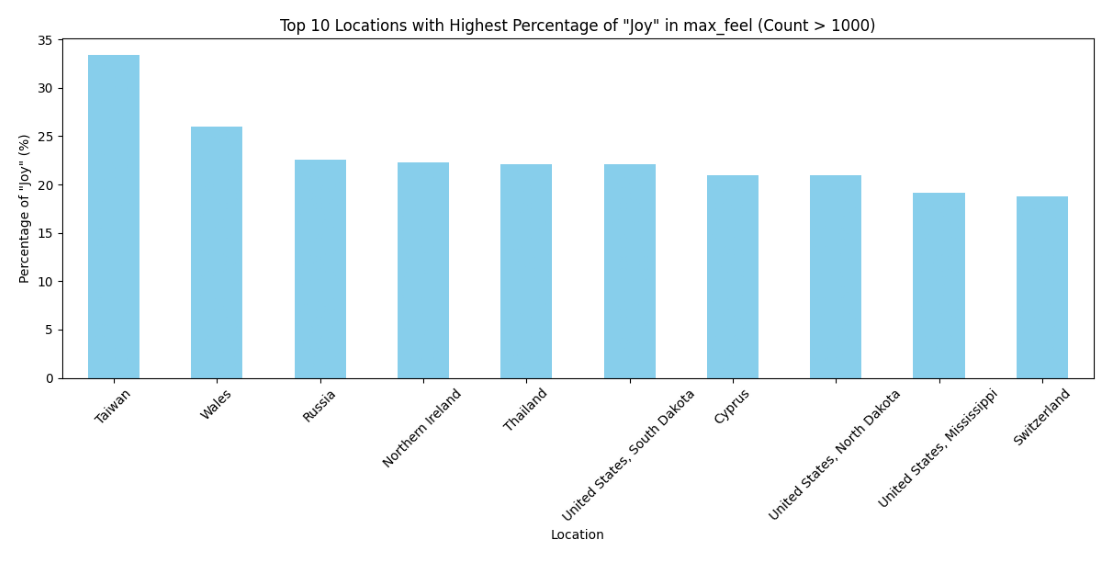

In [160]:
# data = pd.read_pickle("review_with_emotions.pkl")
# threshold = 1000
# emotion_name = "joy"
# top_n = 10
# plot_top_loc_emotion(data, threshold, emotion_name, top_n)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig, ax = plt.subplots(figsize=(12, 6))
img = mpimg.imread('graphs/max_joy_by_loc.png')
ax.imshow(img)
plt.tight_layout()
plt.axis('off')
plt.show()

In [161]:
### adding analysis of ratings by location, beer style, abv